## Weather Prediction:  A comparision of traditional and modern methods

In this study, we are going to use Python and Machine Learning to build models to predict weather temperatures based off data from WorldWeatherOnline. There are three "phases" to this study:

1. Data collection and processing (i.e. like doing an experiment!)
2. Using Linear Regression models (i.e. a traditional fitting approach)
3. Using Neural Network models (i.e. a machine-learning approach)

The data used will be collected from the WorldWeatherOnline API web services. We will interact with the API to pull in weather data over a given time period, for a given location.

Once collected, the data will need to be processed and aggregated into a format that is suitable for data analysis, and then cleaned.

In [1]:
# import the usual libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# We are going to need several additional libraries.  We import them here, but
# I will discuss their purpose and give further details as they are used.

dark_mode = True
# plotting choices for dark-mode ... comment out if not using dark mode!!!
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

In [2]:
import os
os.chdir("/home/brash/Phys421/WWO")
df1 = pd.read_csv('regina.csv')
df2 = pd.read_csv('regina_2018.csv')
df3 = pd.read_csv('regina_2017.csv')

In [3]:
# Create new feature columns ... the idea is that we are going to
# try to predict the temperature for tomorrow by looking at what
# happened today, and for the past three days.

# For each feature that we think might be an important factor in
# determining out temperature forecast, we will add a column to the
# dataframe for this variable for each of the previous three days.
#
# The factor 8*N takes into account that the data in our dataframe
# is reported once every three hours (or 8 times per day)

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*8*N + [df[feature][i-8*N] for i in range(8*N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [4]:
# These are the features/variables that we think a priori might be
# important in our forecasting model

features = ["date_time", "tempC", "DewPointC","pressure","humidity",
            "maxtempC", "mintempC", "sunHour", "windspeedKmph",
            "winddirDegree","precipMM"]


In [5]:
# Now, for each of these features, add three new columns to the
# dataframe which correspond to yesterday, the day before yesterday,
# and the day before that.  The column names will be the same as
# the name as the original feature, but with _1, _2, or _3 added on.

for feature in features:
    if feature != 'date_time':
        for N in range(1, 4):
            derive_nth_day_feature(df1, feature, N)
            derive_nth_day_feature(df2, feature, N)
            derive_nth_day_feature(df3, feature, N)

In [6]:
# We see now that we have accomplished our task ... a lot of new
# columns have been added!

df1.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,6.320548,-1.304110,0.096986,9.662740,2.778082,45.084932,-2.838014,-0.770548,2.878082,-0.827740,...,9.672928,15.394574,15.407369,15.426796,208.945398,208.695592,208.353591,0.246291,0.246970,0.247652
std,15.216829,13.729361,0.388413,4.160689,1.682609,31.265919,12.333195,17.486786,14.668713,17.401909,...,4.176386,6.757152,6.760687,6.759334,94.242035,94.249179,94.153133,1.124402,1.125876,1.127356
min,-28.000000,-36.000000,0.000000,3.000000,1.000000,0.000000,-40.000000,-46.000000,-36.000000,-46.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-6.000000,-12.000000,0.000000,5.900000,1.000000,17.000000,-10.000000,-14.000000,-8.000000,-14.000000,...,5.900000,10.000000,10.000000,10.000000,130.000000,129.000000,129.000000,0.000000,0.000000,0.000000
50%,8.000000,1.000000,0.000000,9.200000,2.000000,44.000000,-2.000000,1.000000,4.000000,1.000000,...,9.300000,14.000000,14.000000,14.000000,217.000000,216.500000,216.000000,0.000000,0.000000,0.000000
75%,20.000000,11.000000,0.000000,13.500000,4.000000,72.000000,7.000000,14.000000,15.000000,14.000000,...,13.500000,19.000000,19.000000,19.000000,297.000000,297.000000,296.000000,0.000000,0.000000,0.000000
max,32.000000,21.000000,3.400000,16.700000,7.000000,100.000000,19.000000,33.000000,33.000000,31.000000,...,16.700000,46.000000,46.000000,46.000000,358.000000,358.000000,358.000000,33.400000,33.400000,33.400000


In [7]:
df2.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,7.824658,-0.356164,0.069041,10.023836,2.969863,46.734247,-2.088014,0.217808,3.687329,0.176712,...,10.060773,15.223214,15.208678,15.222030,206.478365,206.871212,206.910221,0.054808,0.054855,0.055007
std,14.710897,13.226122,0.403412,4.281772,1.898174,31.277963,10.512825,17.124911,14.409367,17.075983,...,4.275437,7.548558,7.552858,7.556585,94.994980,94.821063,94.883997,0.474435,0.475059,0.475706
min,-23.000000,-29.000000,0.000000,3.000000,1.000000,0.000000,-30.000000,-38.000000,-29.000000,-38.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.000000,-11.000000,0.000000,6.700000,1.000000,19.000000,-9.000000,-13.000000,-7.000000,-13.000000,...,6.700000,10.000000,10.000000,10.000000,136.000000,136.000000,136.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,0.000000,10.100000,2.000000,46.000000,-2.000000,-1.000000,2.000000,-1.000000,...,10.100000,14.000000,14.000000,14.000000,209.000000,209.000000,209.000000,0.000000,0.000000,0.000000
75%,22.000000,12.000000,0.000000,14.500000,5.000000,74.000000,7.000000,16.000000,16.000000,16.000000,...,14.500000,20.000000,20.000000,20.000000,293.000000,293.000000,294.000000,0.000000,0.000000,0.000000
max,41.000000,23.000000,4.300000,16.700000,8.000000,100.000000,21.000000,41.000000,41.000000,41.000000,...,16.700000,42.000000,42.000000,42.000000,360.000000,360.000000,360.000000,13.500000,13.500000,13.500000


In [8]:
df3.describe

<bound method NDFrame.describe of                 date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0     2017-01-01 00:00:00       -14       -19           0.0      6.9        1   
1     2017-01-01 03:00:00       -14       -19           0.0      6.9        1   
2     2017-01-01 06:00:00       -14       -19           0.0      6.9        1   
3     2017-01-01 09:00:00       -14       -19           0.0      6.9        1   
4     2017-01-01 12:00:00       -14       -19           0.0      6.9        1   
...                   ...       ...       ...           ...      ...      ...   
2915  2017-12-31 09:00:00       -23       -29           0.0      3.2        1   
2916  2017-12-31 12:00:00       -23       -29           0.0      3.2        1   
2917  2017-12-31 15:00:00       -23       -29           0.0      3.2        1   
2918  2017-12-31 18:00:00       -23       -29           0.0      3.2        1   
2919  2017-12-31 21:00:00       -23       -29           0.0      3.2       

In [9]:
# We now want to clean up the dataframe, and get rid of columns that
# we are not interested in.  This is not so important in this example,
# but if we are dealing with large dataframes with thousands of columns
# of data, it can really speed things up by condensing things.

# make list of original features we are not interested in
to_remove = [feature 
             for feature in features 
             if feature not in ['date_time','maxtempC', 'mintempC', 'tempC']]
for col in ['DewPointC','pressure','humidity','sunHour',
                'windspeedKmph','winddirDegree','precipMM',
                 'totalSnow_cm','uvIndex','moon_illumination',
                  'moonrise','moonset','sunrise','sunset','FeelsLikeC',
                 'HeatIndexC','WindChillC','WindGustKmph','cloudcover',
                 'visibility','location']:
    to_remove.append(col)

print(to_remove)

# make a list of columns to keep
to_keep = [col for col in df1.columns if col not in to_remove]

print(to_keep)

# select only the columns in to_keep and assign to df
df1 = df1[to_keep]
df2 = df2[to_keep]
df3 = df3[to_keep]

['DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'totalSnow_cm', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'visibility', 'location']
['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2', 'precipMM_3']


In [10]:
df1.head()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
0,2019-01-01 00:00:00,-12,-26,-28,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 03:00:00,-12,-26,-28,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 06:00:00,-12,-26,-27,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 09:00:00,-12,-26,-24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 12:00:00,-12,-26,-18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# the last task is to convert the date_time column from an object into a floating point number
# there are a number of ways that we could do this

df1['date'] = pd.to_datetime(df1['date_time'])    
df1['date_delta'] = (df1['date'] - df1['date'].min())  / np.timedelta64(1,'D')

df2['date'] = pd.to_datetime(df2['date_time'])    
df2['date_delta'] = (df2['date'] - df2['date'].min())  / np.timedelta64(1,'D')

df3['date'] = pd.to_datetime(df3['date_time'])    
df3['date_delta'] = (df3['date'] - df3['date'].min())  / np.timedelta64(1,'D')


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [12]:
df2.head()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date,date_delta
0,2018-01-01 00:00:00,-20,-26,-26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,0.000
1,2018-01-01 03:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 03:00:00,0.125
2,2018-01-01 06:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 06:00:00,0.250
3,2018-01-01 09:00:00,-20,-26,-25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 09:00:00,0.375
4,2018-01-01 12:00:00,-20,-26,-22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 12:00:00,0.500


In [13]:
# Now, let's get rid of the rows that do not have complete data!

df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()

## We are now ready to do a linear regression fit to the data!!

In [14]:
# for our model, we will only include variables where the abs(r) > 0.4 - that is, either
# a strong positive or strong negative correlation.

predictors = ['tempC_1',  'DewPointC_1',  'maxtempC_1', 
              'mintempC_1',   'tempC_2',   'DewPointC_2',
              'maxtempC_2', 'mintempC_2', 'tempC_3',
              'DewPointC_3',  'mintempC_3',  'maxtempC_3',
              'pressure_1',  'pressure_2',  'pressure_3',
              'humidity_1',   'humidity_2', 'humidity_3',
              'sunHour_1', 'sunHour_2', 'sunHour_3']
df12 = df1[['date_delta']+['tempC'] + predictors]
df22 = df2[['date_delta']+['tempC'] + predictors]
df32 = df3[['date_delta']+['tempC'] + predictors]

In [15]:
# separate our my predictor variables (X) from my outcome variable y
Xtrain = df12[predictors+['date_delta']]
ytrain = df12['tempC']
Xtest = df22[predictors+['date_delta']]
ytest = df22['tempC']
Xval = df32[predictors+['date_delta']]
yval = df32['tempC']

## OK, so I lied ... now we are REALLY read to do the linear regression fit!  We had to prepare the data a bit more, didn't we?

In [16]:
print("Training instances   {}, Training features   {}".format(Xtrain.shape[0], Xtrain.shape[1]))
print("Validation instances {}, Validation features {}".format(Xval.shape[0], Xval.shape[1]))
print("Testing instances    {}, Testing features    {}".format(Xtest.shape[0], Xtest.shape[1]))

Training instances   2896, Training features   22
Validation instances 2896, Validation features 22
Testing instances    2896, Testing features    22


In [17]:
import tensorflow as tf

In [18]:
feature_cols = [tf.feature_column.numeric_column(col) for col in Xtrain.columns]

In [19]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [20]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [21]:
evaluations = []
STEPS = 400
for i in range(100):
    regressor.train(input_fn=wx_input_fn(Xtrain, y=ytrain), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(Xval,
                                                               yval,
                                                               num_epochs=1,
                                                               shuffle=False)))


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-80000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 80000...
INFO:tensorflow:Saving c

In [22]:
evaluations[0]

{'average_loss': 21.391613,
 'label/mean': 5.5051794,
 'loss': 23.243845,
 'prediction/mean': 4.9715514,
 'global_step': 80400}

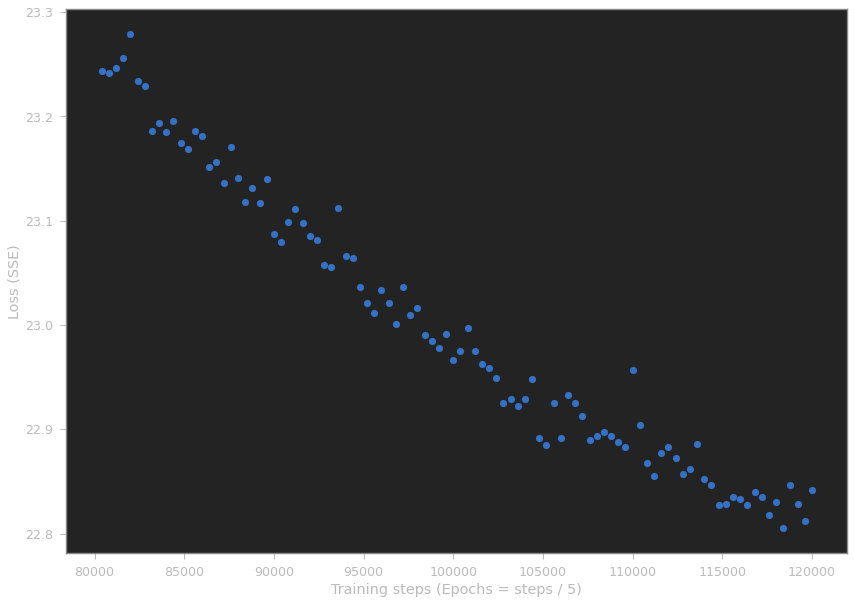

In [23]:
# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 5)')
plt.ylabel('Loss (SSE)')
plt.show()

In [24]:
pred = regressor.predict(input_fn=wx_input_fn(Xtest,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error

print("The Explained Variance: %.2f" % explained_variance_score(
                                            ytest, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            ytest, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            ytest, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 0.90
The Mean Absolute Error: 3.29 degrees Celcius
The Median Absolute Error: 2.61 degrees Celcius


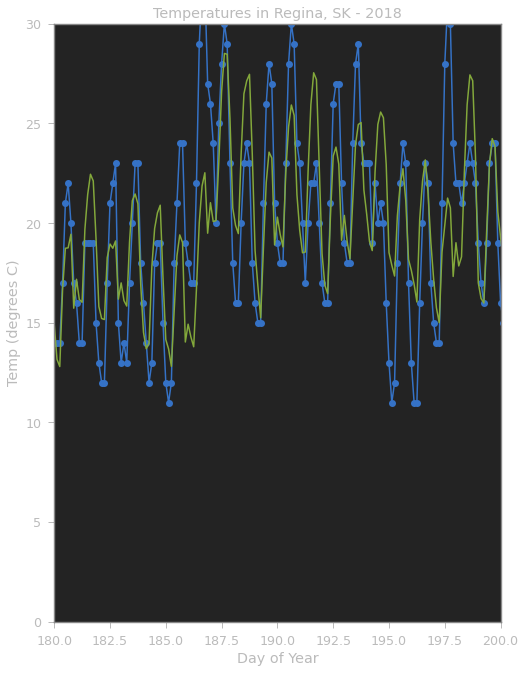

In [25]:
x = Xtest['date_delta']

df_final = pd.DataFrame({'x':x, 'yData':ytest, 'yFit': predictions, 'Residual': ytest-predictions})
df_final = df_final.sort_values(by=['x'])

fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df_final['x'],df_final['yData'],'o-')
axs2.set_ylabel('Temp (degrees C)')
axs2.set_xlabel('Day of Year')
axs2.set_title('Temperatures in Regina, SK - 2018')
axs2.set_xlim(180,200)
axs2.set_ylim(0,30)
axs2.plot(df_final['x'],df_final['yFit'])

plt.show()


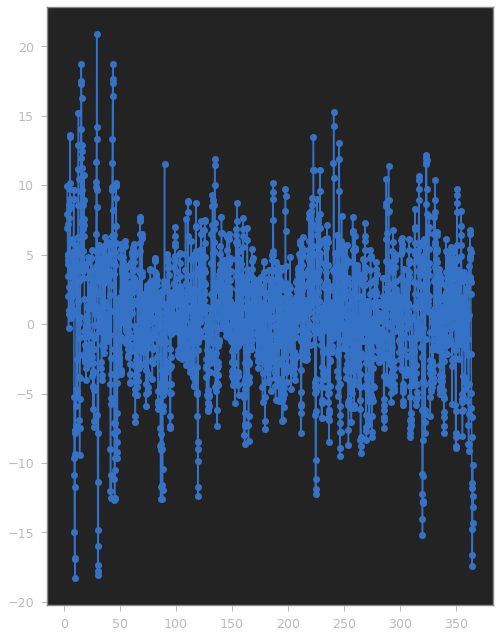

In [26]:
fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df_final['x'],df_final['yData']-df_final['yFit'],'o-')

(array([  2.,   1.,   2.,   2.,   1.,   1.,   0.,   1.,   3.,   0.,   2.,
          0.,   0.,   2.,   7.,   5.,   7.,   2.,   5.,   3.,   1.,   4.,
          5.,   8.,  11.,   9.,  15.,  17.,  19.,  21.,  23.,  20.,  30.,
         38.,  35.,  62.,  48.,  62.,  65.,  70.,  65.,  92.,  84.,  99.,
        120., 125., 131., 144., 125., 124., 120.,  86., 110.,  89.,  98.,
         81.,  88.,  61.,  75.,  60.,  48.,  44.,  29.,  22.,  24.,  13.,
         15.,  12.,  15.,  13.,   4.,  14.,   8.,   6.,   2.,   6.,   8.,
          4.,   1.,   3.,   2.,   3.,   2.,   1.,   0.,   2.,   0.,   0.,
          2.,   0.,   2.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          1.]), array([-18.25030708, -17.85904549, -17.46778389, -17.07652229,
        -16.6852607 , -16.2939991 , -15.9027375 , -15.51147591,
        -15.12021431, -14.72895271, -14.33769112, -13.94642952,
        -13.55516792, -13.16390633, -12.77264473, -12.38138313,
        -11.99012154, -11.59885994, -11.20759834, -10.81633675,

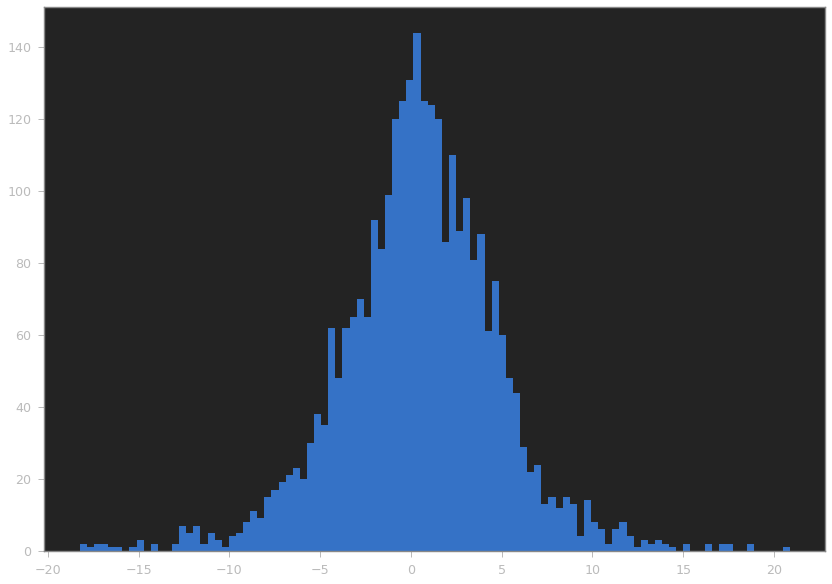

In [27]:
plt.hist(df_final['yData']-df_final['yFit'],bins=100)

0.4496461403032299 4.376141539489994


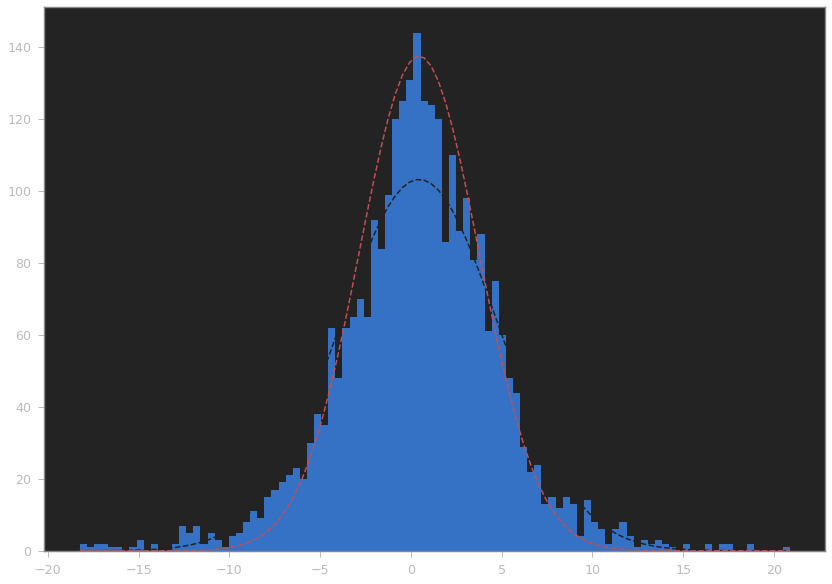

In [28]:
# best fit of data
data = df_final['yData']-df_final['yFit']
(mu, sigma) = stats.norm.fit(data)
print (mu,sigma)

# Empirical average and variance are computed
nbins = 100
avg = mu
var = sigma**2
N = len(df_final)
# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(np.min(data),np.max(data),nbins)
bin_size = (np.max(data) - np.min(data))/nbins
pdf_y = N*bin_size/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

var_mean = (mean_absolute_error(ytest, predictions)**2)
pdf_y2 = N*bin_size/np.sqrt(2*np.pi*var_mean)*np.exp(-0.5*(pdf_x-avg)**2/var_mean)

plt.hist(data,bins=100)
plt.plot(pdf_x,pdf_y,'k--')
plt.plot(pdf_x,pdf_y2,'r--')
plt.show()